In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
%matplotlib inline
import os
import math
import scipy.integrate as integrate

In [6]:
# filename = '/home/xams/xams/PMT12_gain/K_series/K0800.hdf5'
dirname = '/home/xams/lena/run8/processed/pmtdata/'
runname = '170313_100816'
if not os.path.exists(dirname + runname + '.hdf5'):
    raise FileNotFoundError("not found")
    
store = pd.HDFStore(dirname + runname + '.hdf5')
data= store['all_hits']
datapmt1 = data[data['channel'] == 3]
datapmt2 = data[data['channel'] == 0]
melecs1 = datapmt1['area']/1e6
melecs2 = datapmt2['area']/1e6

print(len(datapmt1))

1009409


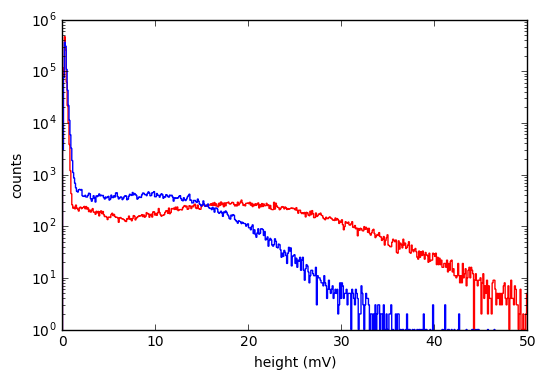

In [8]:
histboundaries = [0,50]
histbinwidth = 0.1
histbins = np.arange(histboundaries[0], histboundaries[1]+histbinwidth, histbinwidth)
centers = np.arange(histboundaries[0]+histbinwidth/2.0, histboundaries[1], histbinwidth)

heights1 = datapmt1['height']*1.602e-19/2e-9*50*1000
heights2 = datapmt2['height']*1.602e-19/2e-9*50*1000

hist1 = plt.hist(heights1, bins=histbins, histtype='step', color = 'red')
hist2 = plt.hist(heights2, bins=histbins, histtype='step', color = 'blue')
counts1 = hist1[0]
counts2 = hist2[0]
countserr1 = [np.sqrt(t)+0.5 for t in counts1]
countserr2 = [np.sqrt(t)+0.5 for t in counts2]

plt.xlabel("height (mV)")
plt.ylabel("counts")
plt.yscale('log')
# plt.ylim(0,200)
plt.show()

[  7.01938734e+04   1.80790911e-01   1.13168855e-01   1.87973186e+02
   7.73225499e-01   1.17293133e+00]
[  3.11853845e+04   3.89846717e-01   7.34660784e-02   1.18846171e+06
  -3.89820822e+00   1.34249305e+00]


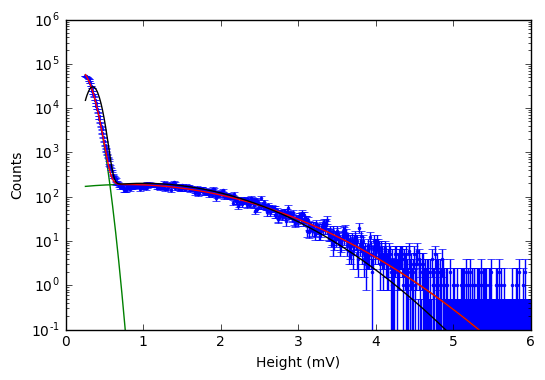

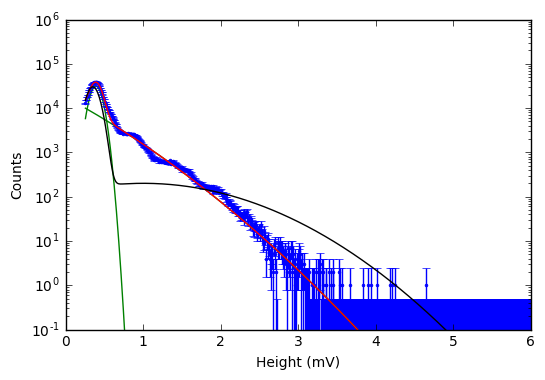

In [6]:
def doublegauss(x, a1, b1, s1, a2, b2, s2):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2)) + a2 * np.exp(-(x-b2)**2/(2*s2**2))

def gauss(x, a1, b1, s1):
    return a1 * np.exp(-(x-b1)**2/(2*s1**2))

def xgauss(x, a1, b1, s1):
    return a1 * x * np.exp(-(x-b1)**2/(2*s1**2))
# 0800v
a1g = 3e4
b1g = 0.35
s1g = 0.08

a2g = 2e2
b2g = 1
s2g = 1

# 0900v:
# a1g = 2e5
# b1g = 0.25
# s1g = 0.08

# a2g = 500
# b2g = 2
# s2g = 4

popt1, pcov1 = curve_fit(doublegauss, centers, counts1, sigma = countserr1, p0=[a1g, b1g, s1g, a2g, b2g, s2g])
popt2, pcov2 = curve_fit(doublegauss, centers, counts2, sigma = countserr2, p0=[a1g, b1g, s1g, a2g, b2g, s2g])
perr1 = np.sqrt(np.diag(pcov1))
perr2 = np.sqrt(np.diag(pcov2))
a1f1, b1f1, s1f1, a2f1, b2f1, s2f1 = popt1
a1f2, b1f2, s1f2, a2f2, b2f2, s2f2 = popt2

print(popt1)
print(popt2)
# print("  ")

fitcounts1 = [doublegauss(t, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4], popt1[5]) for t in centers]
fitcounts2 = [doublegauss(t, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4], popt2[5]) for t in centers]
gescounts = [doublegauss(t, a1g, b1g, s1g, a2g, b2g, s2g) for t in centers]
noscounts1 = [gauss(t, popt1[0], popt1[1], popt1[2]) for t in centers]
noscounts2 = [gauss(t, popt2[0], popt2[1], popt2[2]) for t in centers]
sigcounts1 = [gauss(t, popt1[3], popt1[4], popt1[5]) for t in centers]
sigcounts2 = [gauss(t, popt2[3], popt2[4], popt2[5]) for t in centers]


plt.plot(centers, noscounts1, color='green', linewidth = 1)
plt.plot(centers, sigcounts1, color='green', linewidth = 1)
plt.errorbar(centers, counts1, yerr = countserr1, fmt = '.', markersize = 4)
plt.plot(centers, fitcounts1, color='red', linewidth = 1)
plt.plot(centers, gescounts, color='black', linewidth = 1)
plt.xlabel("Height (mV)")
plt.ylabel("Counts")
plt.yscale('log')
plt.xlim()
plt.ylim(1e-1,10e5)
# plt.ylim(0,200)
plt.savefig('775vpmt1DOOB.eps', format='eps')
plt.show()



plt.plot(centers, noscounts2, color='green', linewidth = 1)
plt.plot(centers, sigcounts2, color='green', linewidth = 1)
plt.errorbar(centers, counts2, yerr = countserr2, fmt = '.', markersize = 4)
plt.plot(centers, fitcounts2, color='red', linewidth = 1)
plt.plot(centers, gescounts, color='black', linewidth = 1)
plt.xlabel("Height (mV)")
plt.ylabel("Counts")
plt.yscale('log')
plt.xlim()
plt.ylim(1e-1,10e5)
# plt.ylim(0,300)
plt.savefig('775vpmtDOOB.eps', format='eps')
plt.show()








In [7]:
def signal_acceptance_pmt1(x):
    totalsignal = integrate.quad(gauss, 0, np.inf, args = (a2f1, b2f1, s2f1))[0]
    cutsignal = integrate.quad(gauss, x, np.inf, args = (a2f1, b2f1, s2f1))[0]
    return cutsignal/totalsignal

def signal_acceptance_pmt2(x):
    totalsignal = integrate.quad(gauss, 0, np.inf, args = (a2f2, b2f2, s2f2))[0]
    cutsignal = integrate.quad(gauss, x, np.inf, args = (a2f2, b2f2, s2f2))[0]
    return cutsignal/totalsignal

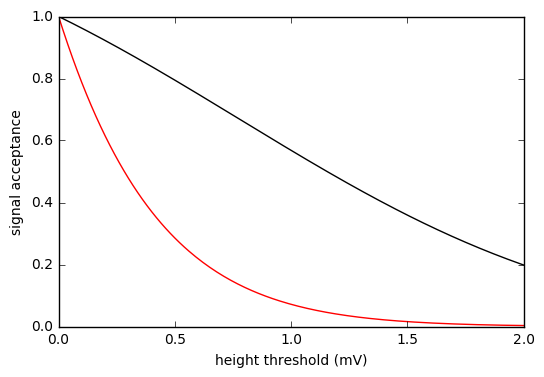

In [14]:
xrange = np.arange(0,4,0.01)
sapmt1 = [signal_acceptance_pmt1(x) for x in xrange]
nrpmt1 = [noise_acceptance_pmt1(x) for x in xrange]
sapmt2 = [signal_acceptance_pmt2(x) for x in xrange]
nrpmt2 = [noise_acceptance_pmt2(x) for x in xrange]

plt.plot(xrange, sapmt1, color = 'black')
plt.plot(xrange, sapmt2, color = 'red')
plt.xlabel('height threshold (mV)')
plt.ylabel('signal acceptance')
plt.ylim(0,1)
plt.xlim(0,2)
plt.savefig('signal_accept.pdf', format='pdf')
plt.show()

In [ ]:
noisesigmalist1 = list(datapmt1['noise_sigma'])
variancelist1 = [x*x for x in noisesigmalist1]
avgvariance1 = sum(variancelist1)/float(len(variancelist1))
noise_sigma1 = np.sqrt(avgvariance1)*1.602e-19/2e-9*50*1000
print(noise_sigma1)

noisesigmalist2 = list(datapmt2['noise_sigma'])
variancelist2 = [x*x for x in noisesigmalist2]
avgvariance2 = sum(variancelist2)/float(len(variancelist2))
noise_sigma2 = np.sqrt(avgvariance2)*1.602e-19/2e-9*50*1000
print(noise_sigma2)

def noise_hit_chance_pmt1(x):
    return integrate.quad(gauss, x/noise_sigma1, np.inf, args = (1/np.sqrt(2*math.pi), 0, 1))[0]

def noise_hit_chance_pmt2(x):
    return integrate.quad(gauss, x/noise_sigma2, np.inf, args = (1/np.sqrt(2*math.pi), 0, 1))[0]

In [ ]:
noisehitinwindow1 = [1- (1 - noise_hit_chance_pmt1(x))**50 for x in xrange]
noisehitinwindow2 = [1- (1 - noise_hit_chance_pmt2(x))**50 for x in xrange]

plt.plot(xrange, noisehitinwindow1, color = 'red')
plt.plot(xrange, napmt1, color = 'black')
plt.show()

plt.plot(xrange, noisehitinwindow2, color = 'red')
plt.plot(xrange, napmt2, color = 'black')